In [4]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [8]:
df['price'].iplot(logy=True)

In [9]:
## perform a dickey-fuller test for seasonality on BTC
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [21]:
adf_test(df2['price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.715635
p-value                    0.423075
# lags used               28.000000
# observations          2574.000000
critical value (1%)       -3.432893
critical value (5%)       -2.862664
critical value (10%)      -2.567368
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


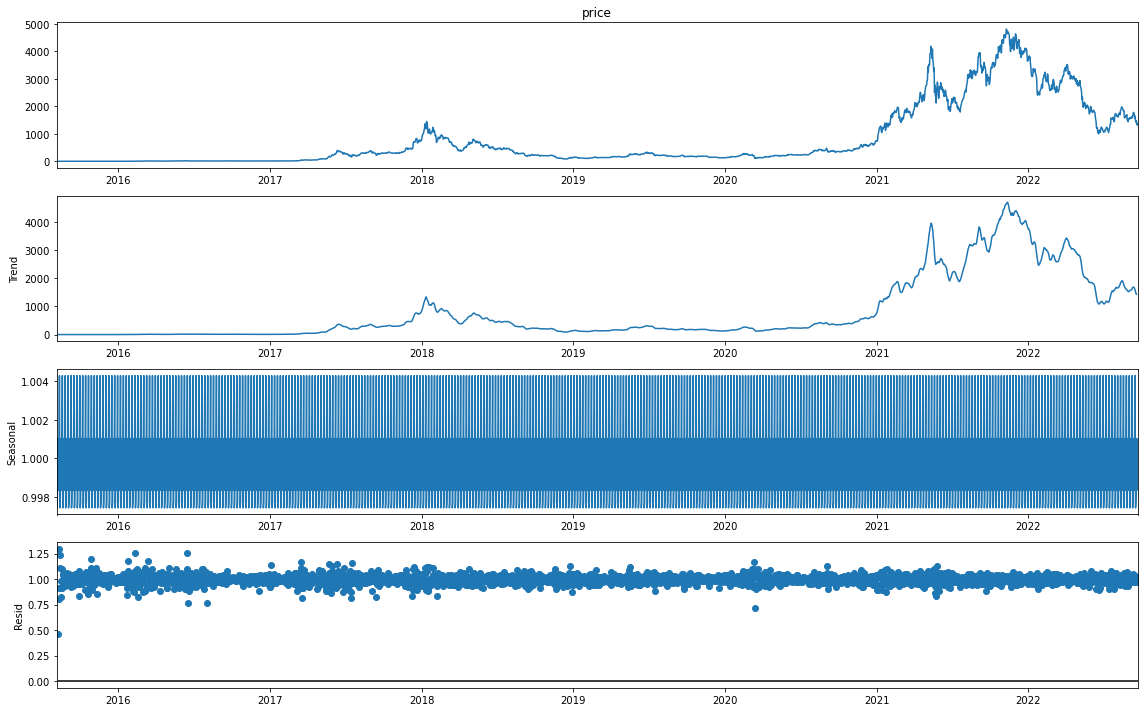

In [22]:
# perform an ETS decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['price'], model='multiplicative')  # model='mul' also works
from pylab import rcParams
rcParams['figure.figsize']= 16,10
result.plot();

In [18]:
# use auto arima to find possible p, d, q values
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
# run auto_arima to evaluate p,d and q with defauls parameters
auto_arima(df2['price'], seasonal=False)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
# we can derive the above 1,1,1 values manually
# first we see if I so 1 differentiation is enough for the data to be stationary
# as seen above currnet p for dickey fuller is 0.423075 which shows trend and seasonality
# the result we get is a p value close to zero so with 1
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic     -8.561135e+00
p-value                 8.689160e-14
# lags used             2.800000e+01
# observations          2.573000e+03
critical value (1%)    -3.432894e+00
critical value (5%)    -2.862664e+00
critical value (10%)   -2.567368e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
